In [1]:
import pandas as pd
import gsheets

In [2]:
gs = gsheets.gsheet("stocks")

Connected to: stocks 19g29uU2VEti127DxANF_nxTubUlt0oK2ebuIMdnbe24 using account: googlesheets@jinlee-8.iam.gserviceaccount.com


In [3]:
df = gs.concat(3)

In [4]:
cols = ['Date', 'PK.Opening', 'PK-SG.Opening', 'PK.Closing Stock', 'PK-SG.Closing Stock', \
        'PKEC.Opening (GT)', 'PKEC.Opening (JL)', 'PKEC.Closing (GT)', 'PKEC.Closing (JL)', \
        'PK-Total.Processed', 'CPKO-Total.Production', 'PKEC.Production']

stock = df[cols].copy()

In [5]:
def convert(df):
    """
    Convert datatypes of a dataframe
    """
    # Convert Date column to datetime and set as index
    df.Date = df.Date.apply(pd.to_datetime, format='%d/%m/%Y')
    df.set_index(df.Date, inplace=True)    
    
    # Convert all non-Date columns to numeric
    df[[col for col in df.columns if not col == 'Date']] = \
    df[[col for col in df.columns if not col == 'Date']].replace(',', '', regex=True).apply(pd.to_numeric)
    
    return df

stock = convert(stock)

In [6]:
def generate_adj_dates():
    """
    Adjust dates as necessary to get date ranges for adjustments and processing
    """
    # Get dates for adjustment of stocks
    # Previous month end date and current month start date
    adj_start = pd.date_range(start='12/1/2017', end='30/11/2019', freq='M').strftime('%Y%m%d')
    adj_end = pd.date_range(start='1/1/2018', end='31/12/2019', freq='MS').strftime('%Y%m%d')
    
    # Get dates for processing of products
    # First and last dates of current month
    proc_start = pd.date_range(start='1/1/2018', end='31/12/2019', freq='MS').strftime('%Y%m%d')
    proc_end = pd.date_range(start='1/1/2018', end='31/12/2019', freq='M').strftime('%Y%m%d')
    
    # Return 2 dictionaries of dates
    return dict(enumerate(zip(adj_start, adj_end), 1)), dict(enumerate(zip(proc_start, proc_end), 1))

adj_dates, proc_dates = generate_adj_dates()

In [7]:
today = pd.to_datetime('today').strftime('%Y%m%d')

_date = []
_cpko_yield = []
_pkec_yield = []

_pk_processed = []
_cpko_processed = []
_pkec_processed = []

for i in range(2,25):
    # Adjustment dfs to use adjustment dates
    for adj_df in [stock.loc[adj_dates[i][0]:adj_dates[i][1]]]:
        # Processing dfs to use processing dates
        for proc_df in [stock.loc[proc_dates[i-1][0]:proc_dates[i-1][1]]]:                
            # If today is greater than the start date of the month, run the program
            if today > proc_dates[i][0]:
                # Get adjustments by Opening (next month) - Closing (previous month)
                # PK Adjustments (to calculate CPKO Yield)
                pk_opening = adj_df.iloc[1, 1:3].sum()
                pk_closing = adj_df.iloc[0, 3:5].sum()
                pk_adj = pk_opening - pk_closing    
                
                # PKEC Adjustments (to calculate PKEC Yield)
                pkec_opening = adj_df.iloc[1, 5:7].sum()
                pkec_closing = adj_df.iloc[0, 7:9].sum()
                pkec_adj = pkec_opening - pkec_closing 

                # Get total processed by product
                pk_processed = proc_df.iloc[:, -3].sum()
                cpko_processed = proc_df.iloc[:, -2].sum()
                pkec_processed = proc_df.iloc[:, -1].sum()
                
                # Append processed to list
                _pk_processed.append(pk_processed)
                _cpko_processed.append(cpko_processed)
                _pkec_processed.append(pkec_processed)

                # Get CPKO and PKEC yield
                pkec_yield = (pkec_processed + pkec_adj) / (pk_processed - pk_adj)
                cpko_yield = cpko_processed / (pk_processed - pk_adj)
                
                # Append period and actual yield to list
                _date.append(proc_dates[i-1][0])
                _cpko_yield.append(cpko_yield)
                _pkec_yield.append(pkec_yield)
                

                print("    *******************************")
                print('    Reporting Period    : ' + f'{proc_dates[i-1][0]:^10}')
                print("    *******************************")
                print('    PK Processed        : ' + f'{pk_processed:9.3f}')
                print('+/- PK Adjustment       : ' + f'{-pk_adj:9.3f}')
                print('    ===============================')
                print('=         Total PK      : ' + f'{(pk_processed - pk_adj):9.3f}')
                print('    ===============================')
                print('         Total CPKO     : ' + f'{cpko_processed:9.3f}')
                print("         CPKO Yield     : " + f'{cpko_yield:9.2%}')
                print('    -------------------------------')
                print('    PKEC Processed      : ' + f'{pkec_processed:9.3f}')
                print('+/- PKEC Adj.           : ' + f'{pkec_adj:9.3f}')
                print('    ===============================')
                print('=        Total PKEC     : ' + f'{(pkec_processed + pkec_adj):9.3f}')
                print('    ===============================')
                print("         PKEC Yield     : " + f'{pkec_yield:9.2%}')
                print('    -------------------------------')
                print('\n')


    *******************************
    Reporting Period    :  20180101 
    *******************************
    PK Processed        : 23011.605
+/- PK Adjustment       :   107.185
=         Total PK      : 23118.790
         Total CPKO     : 10815.454
         CPKO Yield     :    46.78%
    -------------------------------
    PKEC Processed      : 11505.814
+/- PKEC Adj.           :   150.000
=        Total PKEC     : 11655.814
         PKEC Yield     :    50.42%
    -------------------------------


    *******************************
    Reporting Period    :  20180201 
    *******************************
    PK Processed        : 10419.772
+/- PK Adjustment       :    70.128
=         Total PK      : 10489.900
         Total CPKO     :  4897.292
         CPKO Yield     :    46.69%
    -------------------------------
    PKEC Processed      :  5209.892
+/- PKEC Adj.           :   259.377
=        Total PKEC     :  5469.269
         PKEC Yield     :    52.14%
    --------------------

In [8]:
def get_yield_df():
    product_yield_dict = dict(zip(_date, zip(_cpko_yield, _pkec_yield, _pk_processed, _cpko_processed, _pkec_processed)))
    df = pd.DataFrame(product_yield_dict.items(), columns=['Date', 'Yields'])
    df2 = df.Yields.apply(pd.Series)
    concat =  pd.concat([df, df2], axis=1).drop(['Yields'], axis=1).\
              rename(columns={0: 'CPKO Yield',
                              1: 'PKEC Yield',
                              2: 'PK Processed',
                              3: 'CPKO Processed', 
                              4: 'PKEC Processed'})
    concat.Date = pd.to_datetime(concat.Date, format='%Y%m%d')
    concat.set_index('Date', inplace=True)
    return concat

yield_df = get_yield_df()
yield_df

,CPKO Yield,PKEC Yield,PK Processed,CPKO Processed,PKEC Processed
Date,,,,,
2018-01-01,0.467821,0.504171,23011.605,10815.454,11505.814
2018-02-01,0.466858,0.521384,10419.772,4897.292,5209.892
2018-03-01,0.465530,0.502990,19182.580,9015.813,9591.298
2018-04-01,0.470000,0.500000,19465.628,9148.844,9732.822
2018-05-01,0.460594,0.505970,17402.817,8179.323,8701.415
2018-06-01,0.471221,0.506815,18176.890,8543.138,9088.453
2018-07-01,0.465374,0.495079,20406.905,9591.247,10203.460
2018-08-01,0.468302,0.503666,21794.043,10243.200,10897.028
2018-09-01,0.462933,0.504188,21034.714,9886.318,10517.366


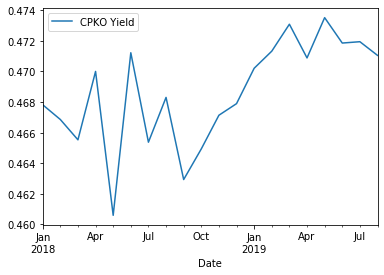

In [11]:
yield_df[['CPKO Yield']].plot()